In [1]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import pandas as pd
from astropy.table import Table, vstack
import hdbscan
from pathlib import Path
import seaborn as sns
import glob
import json
%matplotlib inline
sns.set_color_codes()

In [2]:
ROOT_PATH = Path("..")

In [3]:
df =  pd.read_csv("Fornax.csv")
df[:7]

,ID,RA,DEC,CLASS_STAR,ELLIPTICITY,ELONGATION,FLUX_RADIUS,FWHM,ISOarea,KRON_RADIUS,...,r_aper_6,r_petro,J0660_auto,e_J0660_auto,i_auto,e_i_auto,J0861_auto,e_J0861_auto,z_auto,e_z_auto
0,iDR3.SPLUS-s25s32.020036,49.494328,-32.350563,0.459624,0.449875,1.817768,"[1.242211,2.5662715,5.71492,6.890029]",6.085031,4,7.132851,...,22.020140,22.050888,21.547064,0.332771,20.859621,0.228180,21.274414,0.722951,21.610172,0.819430
1,iDR3.SPLUS-s25s32.020080,50.198927,-32.346923,0.109929,0.570968,2.330827,"[,2.5440927,6.0819097,13.687574,16.590715]",10.850546,6,6.866231,...,21.406225,21.159723,21.103397,0.364895,21.307234,0.578285,19.840270,0.325530,19.682186,0.234320
2,iDR3.SPLUS-s25s32.000003,48.584174,-32.943812,0.354856,0.540795,2.177678,"[1.6309174,6.080961,8.323008,8.323008]",5.599145,3,8.338106,...,21.733967,22.002377,22.599194,0.931227,21.177631,0.337640,23.768717,7.871729,20.785189,0.421435
3,iDR3.SPLUS-s25s32.020094,49.989457,-32.347656,0.359414,0.614246,2.592326,"[1.7771757,4.343724,5.75436,8.281901]",0.000000,1,7.876084,...,22.345322,22.107891,20.608524,0.196191,20.660837,0.268005,20.264135,0.403934,20.136244,0.298935
4,iDR3.SPLUS-s25s32.020131,49.084647,-32.347389,0.001687,0.147096,1.172465,"[1.2690732,2.1671884,2.9067676,4.002029]",10.163368,16,6.591668,...,20.751575,20.507515,20.539282,0.200926,21.079853,0.427792,21.307450,1.145674,20.711657,0.551694
5,iDR3.SPLUS-s25s32.020154,49.120796,-32.346761,0.352127,0.570009,2.325628,"[2.2475142,4.255869,5.7240915,9.093431]",0.000000,0,9.242299,...,21.277360,21.066496,21.307652,0.332644,20.876568,0.290862,20.781640,0.578610,21.313140,0.785182
6,iDR3.SPLUS-s25s32.020167,48.998876,-32.346299,0.079948,0.368976,1.584726,"[1.0609581,1.928098,2.6100047,3.696454]",5.915680,8,6.762239,...,21.842730,21.736881,21.575140,0.382382,22.203756,0.887705,20.599016,0.441643,20.181122,0.250489


In [4]:
# drop 99 value on the r-band
df = df.mask(df["r_auto"] == 99.) 


In [5]:
df.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
RA,118350.0,52.375484,2.778122,47.555626,50.066332,51.567279,54.607582,59.197326
DEC,118350.0,-34.466654,1.626036,-38.221105,-35.620268,-33.967975,-33.280872,-31.514553
CLASS_STAR,118350.0,0.288229,0.232930,0.000024,0.052841,0.347576,0.431019,0.999889
ELLIPTICITY,118350.0,0.303778,0.173307,0.000090,0.169013,0.289333,0.416806,0.890988
ELONGATION,118350.0,1.557842,0.536062,1.000090,1.203388,1.407130,1.714696,9.173266
FWHM,118350.0,4.649383,3.509200,-22.312414,2.175852,4.797357,6.775927,346.055760
ISOarea,118350.0,12.567047,196.994386,0.000000,1.000000,3.000000,8.000000,42197.000000
KRON_RADIUS,118350.0,6.946760,1.935139,0.000000,6.538283,7.211893,8.126989,12.307342
MU_MAX,118350.0,17.874964,0.962862,9.069814,17.765944,18.115874,18.335602,19.720228
A,118350.0,1.448245,0.682410,0.496715,1.062465,1.362493,1.709479,82.813835


In [6]:
count = np.isinf(df["MU_MAX"]).values.sum()
print("MU_MAX contains " + str(count) + " infinite values")

MU_MAX contains 0 infinite values


In [7]:
# counting infinity in a particular column name
c = np.isinf(df['KRON_RADIUS']).values.sum()
print("KRON_RADIUS contains " + str(c) + " infinite values")

KRON_RADIUS contains 0 infinite values


In [8]:
# checking NaN value
count1 = np.isnan(df["MU_MAX"]).values.sum()
print("MU_MAX contains " + str(count1) + " NaN values")

MU_MAX contains 3845 NaN values


In [9]:
c1 = np.isnan(df['KRON_RADIUS']).values.sum()
print("It contains " + str(c1) + " NaN values")

It contains 3845 NaN values


In [10]:
# removing the nan values
#xx = np.nan_to_num(df_new)
df_new = df.dropna()
len(df_new)

118350

In [11]:
# Select colums
cols = ["KRON_RADIUS", "MU_MAX", "r_auto"]
xx = df_new[cols]
xx.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
KRON_RADIUS,118350.0,6.946760,1.935139,0.000000,6.538283,7.211893,8.126989,12.307342
MU_MAX,118350.0,17.874964,0.962862,9.069814,17.765944,18.115874,18.335602,19.720228
r_auto,118350.0,21.463251,1.297202,7.873619,20.858799,21.478884,22.108029,34.613815


In [12]:
# Cheking if these columns have infinite values
ds = xx.isin([np.inf, -np.inf])
print(ds)

        KRON_RADIUS  MU_MAX  r_auto
0             False   False   False
1             False   False   False
2             False   False   False
3             False   False   False
4             False   False   False
...             ...     ...     ...
122190        False   False   False
122191        False   False   False
122192        False   False   False
122193        False   False   False
122194        False   False   False

[118350 rows x 3 columns]


In [13]:
print("Shape:", xx.shape)

Shape: (118350, 3)


We need to rescale the data. The variables used here have different units.

In [14]:
X = StandardScaler().fit_transform(xx)

# Using HDBSCAN

In [15]:
clusterer = hdbscan.HDBSCAN(min_samples=18, min_cluster_size=80, prediction_data=True).fit(X)
labels = clusterer.labels_

In [16]:
# checking metric
clusterer.metric

'euclidean'

In [17]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_cluster0 = list(labels).count(0)
n_cluster1 = list(labels).count(1)
n_cluster2 = list(labels).count(2)
n_cluster3 = list(labels).count(3)
n_cluster4 = list(labels).count(4)
n_cluster5 = list(labels).count(5)
n_cluster6 = list(labels).count(6)
n_noise_ = list(labels).count(-1)


In [18]:
# Print parameters
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of cluster points 0: %d' % n_cluster0)
print('Estimated number of cluster points 1: %d' % n_cluster1)
print('Estimated number of cluster points 2: %d' % n_cluster2)
print('Estimated number of cluster points 3: %d' % n_cluster3)
print('Estimated number of cluster points 4: %d' % n_cluster4)
print('Estimated number of cluster points 5: %d' % n_cluster5)
print('Estimated number of cluster points 6: %d' % n_cluster6)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 7
Estimated number of cluster points 0: 132
Estimated number of cluster points 1: 186
Estimated number of cluster points 2: 93
Estimated number of cluster points 3: 1643
Estimated number of cluster points 4: 3947
Estimated number of cluster points 5: 82
Estimated number of cluster points 6: 80022
Estimated number of noise points: 32245


/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='MU_MAX', ylabel='KRON_RADIUS'>

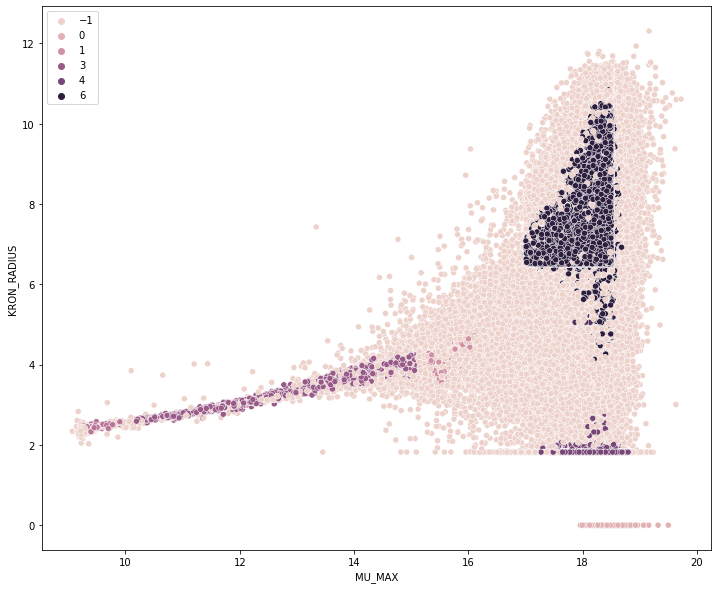

In [19]:
plt.figure(figsize=(12,10))
sns.scatterplot(xx["MU_MAX"], xx["KRON_RADIUS"], 
                hue=labels
                )

In [20]:
df_new["Label"] = labels

<ipython-input-20-22fe855ad4dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["Label"] = labels


Plotting only the objects of the triangle

[(9.0, 20.5), (-0.5, 13.0)]

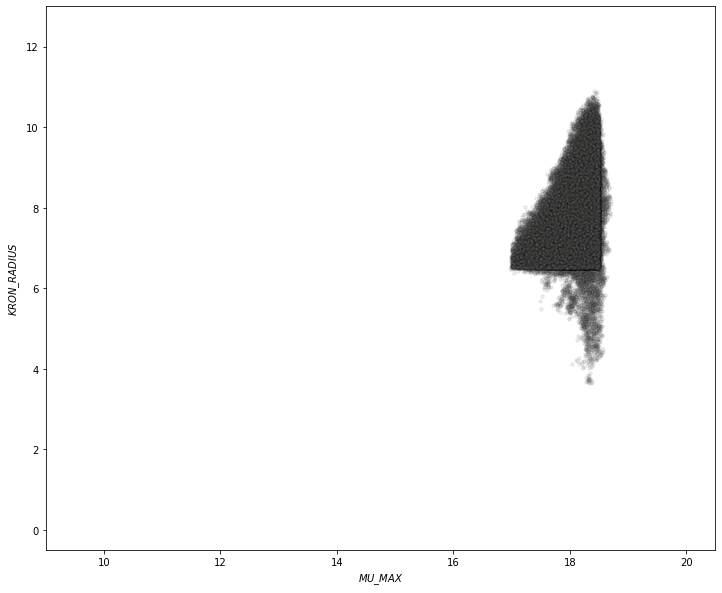

In [21]:
fig, ax = plt.subplots(figsize=(12, 10))

#m = xx["Label"] == 6
ax.scatter(df_new["MU_MAX"][df_new["Label"] == 6], df_new["KRON_RADIUS"][df_new["Label"] == 6],
            c=sns.xkcd_rgb['grey'], s=10, edgecolor='black', alpha=0.1,
            cmap=plt.cm.get_cmap('Accent', 10))
ax.set_xlabel(r'$MU\_MAX$')
ax.set_ylabel(r'$KRON\_RADIUS$')
ax.set(xlim=[9, 20.5], ylim=[-0.5, 13])

In [22]:
print("Number of sources on this cluster:", len(df_new["MU_MAX"][df_new["Label"] == 6]))

Number of sources on this cluster: 80022


$\textbf{Adding the confirmed LSGs}$

In [23]:
df1 =  pd.read_csv("confirmedLSBs_Fornax.csv")
df2 =  pd.read_csv("LSBs_found_23Fornax_prob08-juliana_allinf.csv")

[(9.0, 20.5), (-0.5, 13.0)]

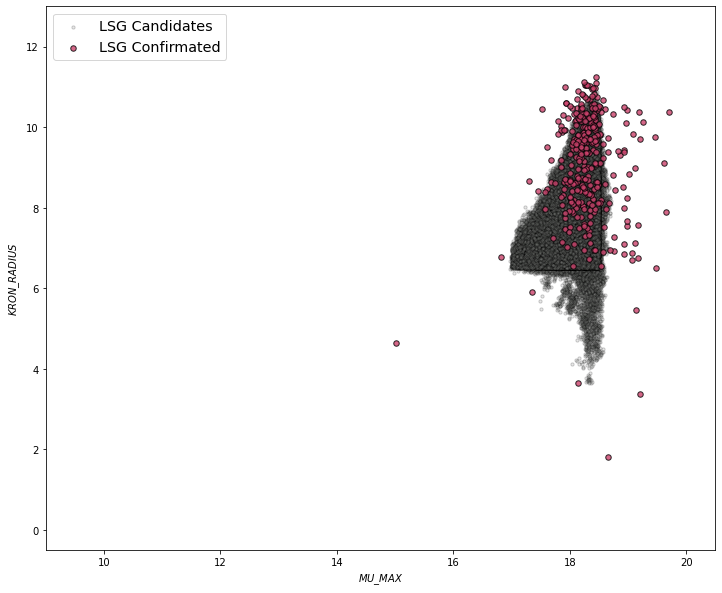

In [24]:
#fig2, ax2 = plt.subplots(1,1, figsize=(13, 10))
fig1, ax1, = plt.subplots(1, 1, figsize=(12, 10))
ax1.scatter(df_new["MU_MAX"][df_new["Label"] == 6], df_new["KRON_RADIUS"][df_new["Label"] == 6], c=sns.xkcd_rgb['grey'], s=10, edgecolor='black', alpha=0.2, label="LSG Candidates")
ax1.scatter(df1["MU_MAX"], df1["KRON_RADIUS"], c=sns.xkcd_rgb['dark pink'], s=30, edgecolor='black', alpha=0.8, zorder=3, label="LSG Confirmated")
ax1.scatter(df2["MU_MAX"], df2["KRON_RADIUS"], c=sns.xkcd_rgb['dark pink'], s=30, edgecolor='black', alpha=0.8, zorder=3)

ax1.set(
    #xlim=[17, 20],
    #ylim=[1, 11],
    xlabel=r"$MU\_MAX$",
    ylabel=r"$KRON\_RADIUS$")
ax1.legend(fontsize="x-large", loc="upper left")
ax1.set(xlim=[9, 20.5], ylim=[-0.5, 13])

As I expected, the high-density zone on the previous plots was identified by HDBSCAN (as a cluster). This cluster coincides with the location of the confirmed LSGs at least on the $\textit{Kron radius}$ versus $\textit{MU Max}$ diagram.

In [52]:
# Mask 
mask = []
for i in range(n_clusters_):
    mask.append(df_new["Label"] == i)

In [57]:
# Applying the masks
clusters = []
for j in range(n_clusters_):
    clusters.append(df_new[mask[j]])
print("# cluster 6:", len(clusters[6]))
print(type(clusters[6]))

# cluster 6: 80022
<class 'pandas.core.frame.DataFrame'>


In [58]:
clusters[6].describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
RA,80022.0,53.221784,2.764387,47.555626,50.808254,53.326472,55.413582,59.196921
DEC,80022.0,-34.780420,1.768305,-38.221105,-36.368751,-34.292446,-33.354364,-31.514553
CLASS_STAR,80022.0,0.247278,0.185615,0.000035,0.046841,0.338151,0.399662,0.906787
ELLIPTICITY,80022.0,0.315494,0.162293,0.000289,0.193292,0.300737,0.420872,0.889326
ELONGATION,80022.0,1.571283,0.507671,1.000290,1.239607,1.430077,1.726733,9.035571
FWHM,80022.0,5.183890,2.964479,-22.312414,3.554414,5.550770,7.131606,21.366499
ISOarea,80022.0,5.070368,5.159975,0.000000,2.000000,3.000000,7.000000,75.000000
KRON_RADIUS,80022.0,7.635985,0.943778,3.639110,6.911265,7.467495,8.219261,10.890575
MU_MAX,80022.0,18.085024,0.319961,16.966640,17.901582,18.157071,18.335354,18.708578
A,80022.0,1.461253,0.462981,0.496715,1.159398,1.404873,1.708771,5.706147


Checking the statistics on cluster 6, which is the cluster that coincides with the confirmed LSGs in the plots, I found that the galaxies of this cluster have by r-magnitude (auto) between  19.3 and 23.3. This result is in agreement with the population of confirmed LSGs.

In [62]:
#writen the cluster
for ii in range(n_clusters_):
    file_name = "cluster-hdbscan/LSGs-candidate-HDBSCAN-cluster-" + str(ii) +".csv"
    clusters[ii].to_csv(file_name, index=False)    

In [63]:
# And the noise?
mask_noise = df_new["Label"] == -1
df_new[mask_noise].to_csv("cluster-hdbscan/LSGs-candidate-HDBSCAN-cluster-noise.csv", index=False)  


# pomegranate 

In [27]:
from pomegranate import GeneralMixtureModel, MultivariateGaussianDistribution
from pomegranate import *

In [28]:
w = np.zeros((356,))

In [29]:
model = GeneralMixtureModel.from_samples(
    distributions=MultivariateGaussianDistribution,
    n_components=2,
    X=X,
    
)


In [30]:
plabels = model.predict(X)
plabels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [31]:
xmin, xmax = 9, 20.5
ymin, ymax = -0.5, 13

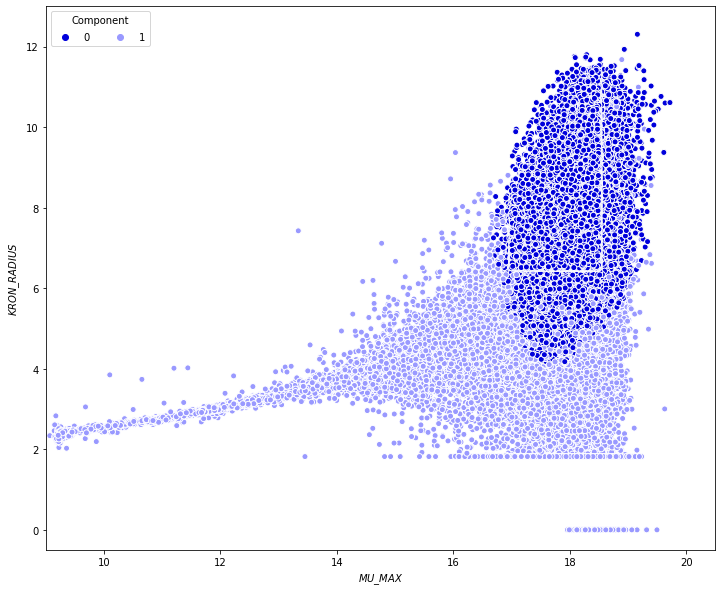

In [32]:
fig2, ax2 = plt.subplots(figsize=(12, 10))
# for k in range(1, N_COMPONENTS):
#    ax.contour(xx, yy, p_components[:, :, k], levels=[0.5], cmap="Reds_r", zorder=-2)
levels = np.array([0.001, 0.003, 0.01, 0.03, 0.1, 1.0])
GAMMA = 0.05
#ax.contourf(
#    xx, yy, p_tot ** GAMMA, levels=levels ** GAMMA, cmap="Greens", zorder=-1, alpha=0.5
#)
scatter = ax2.scatter(
    xx["MU_MAX"],
    xx["KRON_RADIUS"],
    c=plabels,
    #s=5 * np.sqrt(weights),
    edgecolors="w",
    linewidths=1,
    vmin=-1,
    vmax=4,
    cmap="seismic",
)
ax2.set(
    xlim=[xmin, xmax],
    ylim=[ymin, ymax],
    xlabel=r'$MU\_MAX$',
    ylabel=r"$KRON\_RADIUS$",
)
ax2.legend(*scatter.legend_elements(), ncol=2, title="Component")
#ax2.set_aspect("equal")

# Gaussian Mixture Models

In [33]:
from sklearn.mixture import GaussianMixture as GMM

In [34]:
gmm = GMM(n_components=2).fit(X)
labels_gmm = gmm.predict(X)

In [35]:
labels_gmm

array([0, 0, 0, ..., 0, 0, 0])

[(9.0, 20.5),
 (-0.5, 13.0),
 Text(0.5, 0, '$MU\\_MAX$'),
 Text(0, 0.5, '$KRON\\_RADIUS$')]

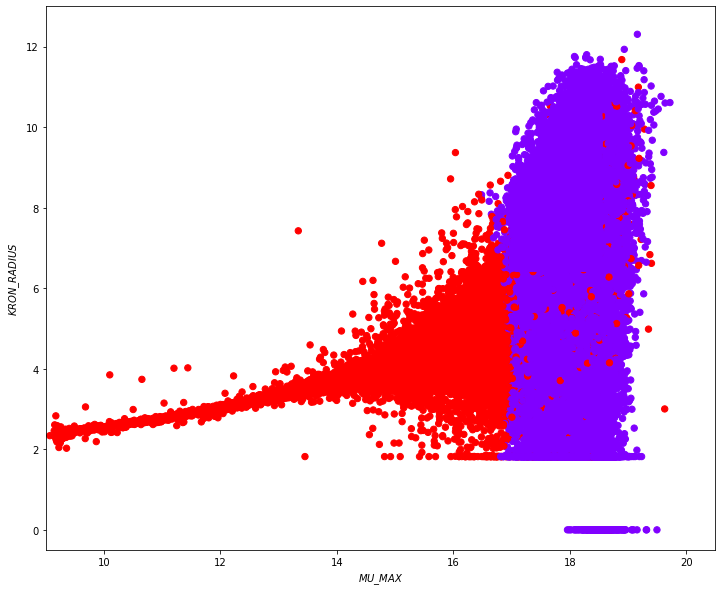

In [36]:
fig3, ax3 = plt.subplots(figsize=(12, 10))
ax3.scatter(df_new["MU_MAX"], df_new["KRON_RADIUS"], 
            c=labels_gmm, s=40, cmap="rainbow")
ax3.set(
    xlim=[9, 20.5],
    ylim=[-0.5, 13],
    xlabel=r'$MU\_MAX$',
    ylabel=r"$KRON\_RADIUS$",
)
#ax3.set_aspect("equal")


# Bayesian Gaussian Mixture to automatically decide how many components

In [37]:
from sklearn.mixture import BayesianGaussianMixture

In [38]:
bgmm = BayesianGaussianMixture(n_components=4, verbose=1).fit(X)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
Initialization converged: False


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


In [39]:
bgmm.weights_

array([0.40871791, 0.36940969, 0.05800008, 0.16387233])

In [40]:
blabels_ = bgmm.predict(X)

In [41]:
blabels_

array([0, 0, 1, ..., 0, 0, 0])

[(9.0, 20.5),
 (-0.5, 13.0),
 Text(0.5, 0, '$MU\\_MAX$'),
 Text(0, 0.5, '$KRON\\_RADIUS$')]

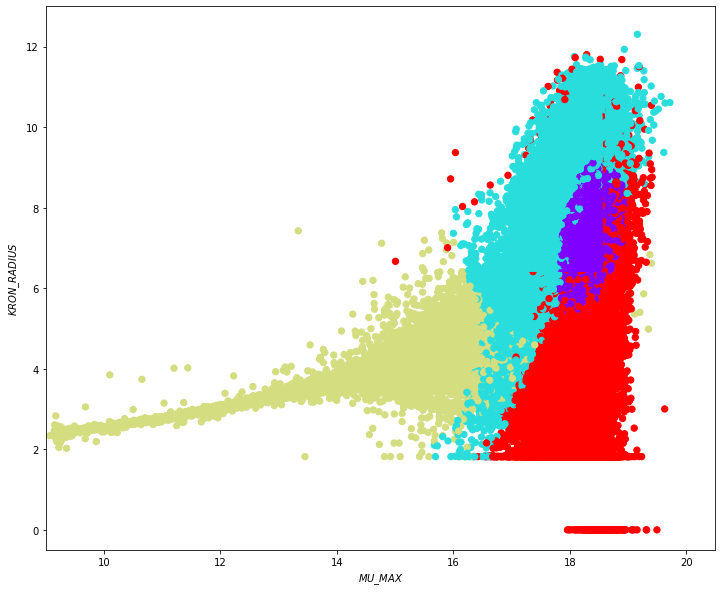

In [42]:
fig4, ax4 = plt.subplots(figsize=(12, 10))
ax4.scatter(xx["MU_MAX"], xx["KRON_RADIUS"], c=blabels_, s=40, cmap="rainbow")
ax4.set(
    xlim=[9, 20.5],
    ylim=[-0.5, 13],
    xlabel=r'$MU\_MAX$',
    ylabel=r"$KRON\_RADIUS$",
)
#ax4.set_aspect("equal")

In [43]:
bgmm = BayesianGaussianMixture(
    n_components=2, verbose=1, weight_concentration_prior=1000.0
).fit(X)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True


In [44]:
bgmm.weights_

array([0.82296819, 0.17703181])

In [45]:
blabels = bgmm.predict(X)
blabels

array([0, 0, 0, ..., 0, 0, 0])

[(9.0, 20.5),
 (-0.5, 13.0),
 Text(0.5, 0, '$MU\\_MAX$'),
 Text(0, 0.5, '$KRON\\_RADIUS$')]

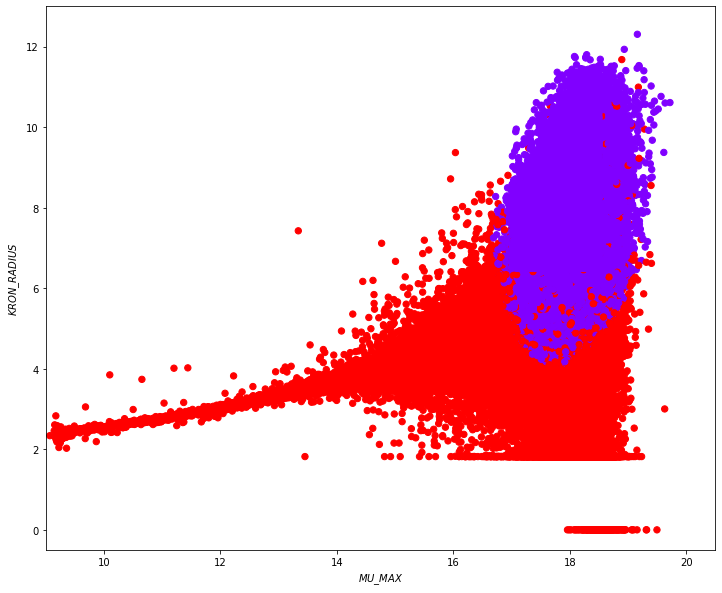

In [46]:
fig5, ax5 = plt.subplots(figsize=(12, 10))
ax5.scatter(df_new["MU_MAX"], df_new["KRON_RADIUS"], c=blabels, s=40, cmap="rainbow")
ax5.set(
    xlim=[9, 20.5],
    ylim=[-0.5, 13],
    xlabel=r'$MU\_MAX$',
    ylabel=r"$KRON\_RADIUS$",
)
#ax4.set_aspect("equal")

There is similar result between pomegranate and Bayesian Gaussian Mixture approaches